# proyecto Final Redes neuronales
#### Nicolas Kano Chavira num. cuenta 315319204

En este proyecto vamos a ser un par de redes convolucionales que reciba imagenes de Pokemon.
La primera red va a ser una red de catalogacion de imagen, dada una imagen va a predecir que pokemon es, la segunda igual va a ser de catalogacion pero dada una imagen va a predecir que tipo o tipos tiene el pokemon


In [1]:
#importamos las bibliotecas que vamos a ocupar en el proyecto
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, interact_manual, interactive, fixed
from PIL import Image
from tqdm.auto import tqdm
import time

In [2]:
#Cargamos las imagenes y etiquetas
dataset = pd.read_csv("./dataset.csv")

In [3]:
dataset

,file,name,type1,type2
0,./sprites/0.png,None,NaN,NaN
1,./sprites/1.png,Bulbasaur,Grass,Poison
2,./sprites/2.png,Ivysaur,Grass,Poison
3,./sprites/3.png,Venusaur,Grass,Poison
4,./sprites/4.png,Charmander,Fire,NaN
...,...,...,...,...
1006,./sprites/1006.png,Iron Valiant,Fairy,Fighting
1007,./sprites/1007.png,Koraidon,Fighting,Dragon
1008,./sprites/1008.png,Miraidon,Electric,Dragon
1009,./sprites/1009.png,Walking Wake,Water,Dragon


In [4]:
# vamos a codificar los tipos y los nombres de los pokemon cambiando los strings por numeros
tipos={np.nan:0,
"Bug":1,
"Dark":2,
"Dragon":3,
"Electric":4,
"Fairy":5,
"Fighting":6,
"Fire":7,
"Flying":8,
"Ghost":9,
"Grass":10,
"Ground":11,
"Ice":12,
"Normal":13,
"Poison":14,
"Psychic":15,
"Rock":16,
"Steel":17,
"Water":18}
name =  {k: v for v, k in enumerate(dataset.name.unique())}
dataset = dataset.replace({'type1':tipos})
dataset = dataset.replace({'type2':tipos})
dataset = dataset.replace({'name':name})
dataset

,file,name,type1,type2
0,./sprites/0.png,0,0,0
1,./sprites/1.png,1,10,14
2,./sprites/2.png,2,10,14
3,./sprites/3.png,3,10,14
4,./sprites/4.png,4,7,0
...,...,...,...,...
1006,./sprites/1006.png,1006,5,6
1007,./sprites/1007.png,1007,6,3
1008,./sprites/1008.png,1008,4,3
1009,./sprites/1009.png,1009,18,3


In [5]:
# randomizamos las entradas
dataset = dataset.sample(frac = 1)
dataset

,file,name,type1,type2
615,./sprites/615.png,615,12,0
207,./sprites/207.png,207,11,8
867,./sprites/867.png,867,11,9
677,./sprites/677.png,677,15,0
579,./sprites/579.png,579,15,0
...,...,...,...,...
879,./sprites/879.png,879,17,0
710,./sprites/710.png,710,9,10
524,./sprites/524.png,524,16,0
396,./sprites/396.png,396,13,8


In [6]:
#creamos los conjuntos para entrenar las redes
# Y va a contener los nombres codificados y se utiliza como las etiquetas correctas
# para la primera red.
Y = dataset['name']

# Y2 va a contener los tipos codificados y se utiliza como las etiquetas correctas
# para la segunda red.
Y2 = dataset.drop(['name','file'],axis=1)

# X va a contener las imagenes que se van a usar como entrada para ambas redes.
X = dataset.drop(['name','type1','type2'],axis=1)

In [7]:
def etiquetaNombres(etiquetas):
    # Esta funcion tomara el dataset de los nombres de los pokemon (codificados en numeros)
    # y regresara un tensor con la representacion de one hot encoding de cada uno
    
    # Tenemos 1011 posibles salidas y segun la codificacion del nombre solo la entrada
    # que sea igual que la codificacion va a ser 1 y las demas 0.
    y = torch.zeros(len(etiquetas),1011)
    for i in range(len(etiquetas)):
        y[i][etiquetas[i]] = 1
    return y

def fotosAtensor(fotos):
    # Esta funcion tomara el dataset de las rutas de los archivos que contienen las fotos
    # que se usaran como entradas y regresara un tensor con los tensores que representan
    # la imagen dividida por canales de color
    
    tensors = torch.zeros(len(fotos),3,30,40)
    transform = transforms.ToTensor()
    for i in range(len(fotos)):
        tensors[i] = transform(Image.open(fotos[i][0]))
    return tensors

In [8]:
# converitmos el dataset de nombres a tensor de etiquetas
Ynombres=etiquetaNombres(Y)
# convertimos el dataset de las rutas de imagenes a el tensor con su representacion
Xtensor = fotosAtensor(X.to_numpy())

In [9]:
# mostramos como se ven las imagenes sin filtros
@interact(img = (0, 1010))
def muestraImagen(img):
    plt.imshow(Image.open('./sprites/'+str(img)+'.png'))

interactive(children=(IntSlider(value=505, description='img', max=1010), Output()), _dom_classes=('widget-inte…

In [10]:
# mostramos como se ve la imagen con el pooling que realizara la red neuronal
@interact(img = (0, 1010))
def muestraImagen2(img):
    transform = transforms.ToTensor()
    tensor = transform(Image.open('./sprites/'+str(img)+'.png'))
    m = nn.AvgPool2d(5)
    r = m(tensor)
    img = r.squeeze(0)
    img = transforms.ToPILImage()(img)
    plt.imshow(img)


interactive(children=(IntSlider(value=505, description='img', max=1010), Output()), _dom_classes=('widget-inte…

## Red para nombre del pokemon

In [11]:
class redNombre(nn.Module):
    def __init__(self):
        
        super(redNombre, self).__init__()
        # capas que va a tener nuestra red
        
        # una capa de pooling que tomara el promedio de los pixeles de la matris
        # utiliza una matriz de 5x5 con stride de 5 y sin padding
        # convierte nuestra imagen de 3x30x40 en una de 3x6x8
        self.pool = nn.AvgPool2d(5)
        
        # Una capa convolucional que transforma nuesta imagen de 3x6x8 a una de 5x5x7
        self.conv = nn.Conv2d(3,5,kernel_size=2,stride=1,padding=0)
        
        # Una capa convolucional que transforma nuesta imagen de 5x5x7 a una de 3x4x6
        self.conv2 = nn.Conv2d(5,3,kernel_size=2,stride=1,padding=0)
        
        # Una capa completamente conectada con 150 neuronas,cuya activacion es ReLu
        self.fc0 = nn.Linear(72,150)
        # Una capa completamente conectada con 200 neuronas,cuya activacion es ReLu
        self.fc1 = nn.Linear(150,200)
        # Una capa completamente conectada con 1011 neuronas,cuya activacion es ReLu
        self.fc2 = nn.Linear(200,1011)
        
    def forward(self, x):
        # Orden que van a tener las capas
        
        # primero realizamos el avgpool
        x = self.pool(x)
        
        # despues hacemos las dos covoluciones
        x = nn.functional.relu(self.conv(x))
        x = nn.functional.relu(self.conv2(x))
        
        # reorganizamos la forma del tensor
        x = x.view(-1,72)
        
        # realizamos las tres capas completamente conectadas
        x = nn.functional.relu(self.fc0(x))
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        
        # devolvemos el tensor resultante, la entrada de mayor valor sera la que consideremos como la elegida
        return x
    
    def train(self,epochs,X,Y,criterion,optimizer,cuda=False):
        
        # Metodo que reliza el entrenamiento de los pesos de la red
        
        # Estas dos variables son para graficar el error de la red
        ejeX = []
        ejeY = []
        
        # Por cada epoca:
        for i in tqdm(range(epochs)):
            loss=0.0
            # Por cada entrada "x" y su etiqueta correcta "y"
            for x,y in zip(X,Y):
                optimizer.zero_grad()
                
                # calculamos la prediccion de la red
                output = self.forward(x)
                # calculamos que tanto se equivoco contra la etiqueta correcta
                loss = criterion(output.flatten(),y)
                # actualizamos los pesos
                loss.backward()
                optimizer.step()
            # agregamos el error de la epoca para la grafica
            ejeX += [i]
            ejeY += [loss.item()]
        # graficamos el error de la red a lo largo de las epocas
        plt.plot(ejeX,ejeY)
        
    def _mayores(self,predicciones):
        # Funcion auxiliar para convertir los tensores de prediccion de la red a un one hot encoding
        # por cada tensor la entrada mas grande se convierte en 1 y las demas en 0
        # por ejemplo si un tensor es [0.7,0.8,0.2,0.9,0.1,-0.5] se convierte en [0, 0, 0, 1, 0, 0]
        
        mejores = []
        for pred in predicciones:
            valor = -1
            mejor = -1
            for i in range(len(pred)):
                if pred[i] > valor:
                    valor = pred[i]
                    mejor = i
            mejores += [mejor]
        return mejores
    
    def predicciones(self,entrada):
        # metodo que dado un tensor con entradas para la red regresa el one hot encoding de las predicciones de la red
        return self._mayores(self.forward(entrada)) 

In [12]:
# creamos la red que aprendera los a distinguir los pokemon y predecira su nombre (codificado por el one hot)
rn = redNombre()
criterio = nn.CrossEntropyLoss()
optimizer = optim.SGD(rn.parameters(), lr=0.0015) 

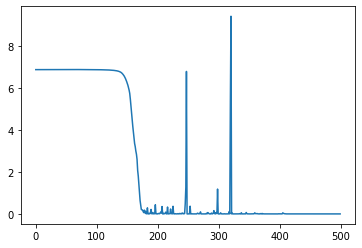

In [13]:
# Entrenamos la red por 500 epocas
rn.train(500,Xtensor,Ynombres,criterio,optimizer,cuda=True)

In [14]:
def salvarRed(red,ruta='./pesos.pth'):
    # Este metodo creara un archivo con los pesos de la red para
    # poder recuperarlos luego y no tener que volver a entrenar la red
    torch.save(red.state_dict(),ruta)
    
def cargarRed(red,ruta='./pesos.pth'):
    # Este metodo cargara los pesos de la red con los que se encuentran 
    # en un archivo para no tener que volver a entrenar la red
    red.load_state_dict(torch.load(ruta))

In [15]:
#salvarRed(rc,ruta='./pesosNombre.pth')

#cargamos la red que correctamente clasifica todos los pokemon
cargarRed(rn,ruta='./pesosNombre.pth')

In [16]:
def contarCorrectas(predictor,X,Y):
    # metodo que dado un metodo para predecir las salidas dadas las entras "X" 
    #  contara cuantas fueron correctas dadas las etiquetas correctas "Y" 
    predicciones = predictor.predicciones(X)
    correctas = 0
    for yPred,yVerd in zip(predicciones,Y):
        if yPred == yVerd:
            correctas += 1
    return correctas

In [17]:
class busquedaTemplate():
    # Clase para busqueda por template, vamos a ocupar las imagenes que ya tenemos en xTensor para solo
    # comparar los tensores hasta tener un match y devolver nuestra prediccion
    def __init__(self, tensores,y):
        # contructor de la clase
        # utilizaremos los tensores que ya tenemos como nuestros templates y
        # utilizaremos los valores de y para saber la etiqueta real de la imagen
        self.imagenes = tensores.clone().detach()
        self.ind = y
    
    def preddicciones(self,entrada):
        resultados = []
        # por cada entrada
        for ent in entrada:
            encontrado = False
            # vamos a comparar uno a uno con nuestros templates para decidir que etiqueta ponerle a la entrada
            for imagen,ind in zip(self.imagenes,self.ind):
                if torch.equal(ent,imagen):
                    encontrado = True
                    resultados += [ind]
                    break
            # si no encontramos la entrada en nuestros templates usamos esta etiqueta
            if not encontrado:
                resultados = [-1]
        return resultados

In [18]:
# para poder comparar el comportamiento entre usar la red convolucional y usar los templates
# vamos a medir cuanto tiempo se tardan cada una.
# aqui calculamos el tiempo que tarda la red convolucional en identificar todos los pokemon
start = time.time()
correctas=contarCorrectas(rn,Xtensor,Y.to_numpy())
end = time.time()
print("tiempo:",end - start,"correctas",correctas)

tiempo: 7.582169532775879 correctas 1011


In [19]:
# creamos el buscador por template
bt = busquedaTemplate(Xtensor,Y.to_numpy())

In [20]:
# aqui calculamos el tiempo que tarda el buscador por template en identificar todos los pokemon
start = time.time()
correctas=contarCorrectas(rn,Xtensor,Y.to_numpy())
end = time.time()
print("tiempo:",end - start,"correctas",correctas)

tiempo: 7.765726566314697 correctas 1011


## red para identificacion de tipos

In [21]:
# estos son los datos de los tipos
Y2

,type1,type2
615,12,0
207,11,8
867,11,9
677,15,0
579,15,0
...,...,...
879,17,0
710,9,10
524,16,0
396,13,8


In [22]:
def combinacionTipos(etiquetas):
    # metodo para convertir las etiquetas de los tipos a un solo valor
    aux = []
    for i in range(len(etiquetas)):
        aux+=[19*etiquetas[i][0]+etiquetas[i][1]]
    return aux

In [23]:
def etiquetaTipos(etiquetas):
    # metodo para hacer el one hot encoding de las etiquetas de los tipos
    y = torch.zeros(len(etiquetas),361)
    for i in range(len(etiquetas)):
        y[i][19*etiquetas[i][0]+etiquetas[i][1]] += 1 
    return y

In [24]:
# creamos las etiquetas de los tipos para el entrenamiento
Ytipos=etiquetaTipos(Y2.to_numpy())

In [25]:
#red que adivina tipos
class redTipos(nn.Module):
    def __init__(self):
        '''
        Construcción de la Red, define las capas que se utiizaran.
        '''
        super(redTipos, self).__init__()
        # capas que va a tener nuestra red
        
        # una capa de pooling que tomara el promedio de los pixeles de la matris
        # utiliza una matriz de 5x5 con stride de 5 y sin padding
        # convierte nuestra imagen de 3x30x40 en una de 3x6x8
        self.pool = nn.AvgPool2d(5)
        
        # Una capa convolucional que transforma nuesta imagen de 3x6x8 a una de 5x5x7
        self.conv = nn.Conv2d(3,5,kernel_size=2,stride=1,padding=0)
        
        # Una capa convolucional que transforma nuesta imagen de 5x5x7 a una de 3x4x6
        self.conv2 = nn.Conv2d(5,3,kernel_size=2,stride=1,padding=0)
        # Una capa completamente conectada con 80 neuronas,cuya activacion es ReLu
        self.fc0 = nn.Linear(72,80)
        # Una capa completamente conectada con 100 neuronas,cuya activacion es ReLu
        self.fc1 = nn.Linear(80,100)
        # Una capa completamente conectada con 361 neuronas,cuya activacion es ReLu
        self.fc2 = nn.Linear(100,361)
        
    def forward(self, x):
        # Orden que van a tener las capas
        
        # primero realizamos el avgpool
        x = self.pool(x)
        
        # despues hacemos las dos covoluciones
        x = nn.functional.relu(self.conv(x))
        x = nn.functional.relu(self.conv2(x))
        
        # reorganizamos la forma del tensor
        x = x.view(-1,72)
        
        # realizamos las tres capas completamente conectadas
        x = nn.functional.relu(self.fc0(x))
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        
        # devolvemos el tensor resultante, la entrada de mayor valor sera la que consideremos como la elegida
        return x
    
    def train(self,epochs,X,Y,criterion,optimizer,cuda=False):
        
        # Metodo que reliza el entrenamiento de los pesos de la red
        
        # Estas dos variables son para graficar el error de la red
        ejeX = []
        ejeY = []
        
        # Por cada epoca:
        for i in tqdm(range(epochs)):
            loss=0.0
            # Por cada entrada "x" y su etiqueta correcta "y"
            for x,y in zip(X,Y):
                optimizer.zero_grad()
                
                # calculamos la prediccion de la red
                output = self.forward(x)
                # calculamos que tanto se equivoco contra la etiqueta correcta
                loss = criterion(output.flatten(),y)
                # actualizamos los pesos
                loss.backward()
                optimizer.step()
            # agregamos el error de la epoca para la grafica
            ejeX += [i]
            ejeY += [loss.item()]
        # graficamos el error de la red a lo largo de las epocas
        plt.plot(ejeX,ejeY)
        
    def _mayores(self,predicciones):
        # Funcion auxiliar para convertir los tensores de prediccion de la red a un one hot encoding
        # por cada tensor la entrada mas grande se convierte en 1 y las demas en 0
        # por ejemplo si un tensor es [0.7,0.8,0.2,0.9,0.1,-0.5] se convierte en [0, 0, 0, 1, 0, 0]
        
        mejores = []
        for pred in predicciones:
            valor = -1
            mejor = -1
            for i in range(len(pred)):
                if pred[i] > valor:
                    valor = pred[i]
                    mejor = i
            mejores += [mejor]
        return mejores
    
    def predicciones(self,entrada):
        # metodo que dado un tensor con entradas para la red regresa el one hot encoding de las predicciones de la red
        return self._mayores(self.forward(entrada)) 

In [26]:
# creamos la red que aprendera a predecir los tipos segun la imagen
rt = redTipos()
criterio = nn.CrossEntropyLoss()
optimizer = optim.SGD(rt.parameters(), lr=0.0015) 

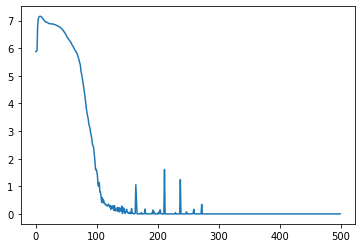

In [27]:
# entrenamos la red por 500 epocas
rt.train(500,Xtensor,Ytipos,criterio,optimizer,cuda=True)

In [28]:
#creamos las etiquetas para ver que tan bien aprendio la clasificacion
YtiposV = combinacionTipos(Y2.to_numpy())

In [29]:
#salvarRed(rt,ruta='./pesosTipos.pth')
#cargamos la red que correctamente clasifica todas las imagenes segun tipo
cargarRed(rt,ruta='./pesosTipos.pth')

In [30]:
start = time.time()
correctas=contarCorrectas(rt,Xtensor,YtiposV)
end = time.time()
print("tiempo:",end - start,"correctas",correctas)

tiempo: 2.6834347248077393 correctas 1011
